Using kernel `conda_pytorch_latest_p36`

In [1]:
# !pip install fastai

In [2]:
classes = [
    'Agricolture',
    'Cross',
    'Education',
    'Food Security',
    'Health',
    'Livelihoods',
    'Logistics',
    'Nutrition',
    'Protection',
    'Shelter',
    'Wash'
]

In [3]:
import torch

In [4]:
from pathlib import Path
import os
import random
import pickle

In [5]:
from fastai.text.all import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [6]:
data = Path('data_prep/final_data/en/')
raw = pd.read_csv('data_prep/data/entries_raw.csv')

In [7]:
train = pd.read_csv(data / 'sentences_en_train.csv')
test = pd.read_csv(data / 'sentences_en_test.csv')

In [8]:
train

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids
0,51787,38,"Climate Change and Agriculture: Subsistence Farmers Response to Extreme Heat.American Economic Journal: Economic Policy, 13(1), 1-35.",0,[]
1,51787,44,"Bohorquez-Penuela, C., & Otero-Cortes, A (2020).",0,[]
2,51787,45,Blame it on the Rain: The Effects of Weather Shocks on Formal Rural Employment in Colombia.Documento de Trabajo sobre Econom a Regional y Urbana; No.,0,[]
3,51787,49,"Increasing frequency of extreme El Ni o events due to greenhouse warming.Nature climate change, 4(2), 111-116.",0,[]
4,51787,53,What do we learn from the weather?,0,[]
...,...,...,...,...,...
191932,34512,112,"Emergency shelters in India had reportedly been converted to COVID-19 isolation centres, decreasing the capacity for evacuation shelters in affected areas (AA 20/05/2020).",0,[]
191933,34512,116,"In these situations humanitarian operations may have been limited to essential services and slowed down, but not come to a complete stop.",0,[]
191934,34512,120,Governments of EU member states and several African states set up a humanitarian air bridge enabling the transport of humanitarian workers and relief items despite flight suspensions (EC 10/06/2020).,0,[]
191935,34512,124,You can find an overview of all ACAPS resources on COVID-19 here.,0,[]


In [9]:
def process_for_sector(df, sector, train):
    relevant_train = df[df.is_relevant == 1]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(eval)
    relevant_train = relevant_train[relevant_train.sector_ids.apply(len) > 0]
    
    positive_train = relevant_train[relevant_train.sector_ids.apply(lambda x: sector in x)]
    negative_train = relevant_train[relevant_train.sector_ids.apply(lambda x: sector not in x)]

    positive_train.sector_ids = 1
    negative_train.sector_ids = 0
    train_df = pd.concat([positive_train, negative_train])
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    train_df['is_valid'] = False if train else True
        
    return train_df

In [10]:
def process_multiclass(df, train):
    relevant_train = df[df.is_relevant == 1]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(eval)
    relevant_train = relevant_train[relevant_train.sector_ids.apply(len) > 0]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(lambda x: ';'.join(classes[i] for i in x))
#     relevant_train.sector_ids = relevant_train.sector_ids.apply(lambda x: [classes[i] for i in x][0])

    
    relevant_train['is_valid'] = False if train else True
    
    return relevant_train
    
    

# Use fastai

In [11]:
train_df = process_multiclass(train, True)
test_df = process_multiclass(test, False)
df = pd.concat([train_df, test_df])

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [85]:
dls = TextDataLoaders.from_df(
    df,
    text_col='sentence_text',
    label_col='sector_ids',
    label_delim=';',
    valid_col='is_valid',
    is_lm = False,    # Mention explicitly that this dataloader is meant for language model
    seq_len = 72,     # Pick a sequence length i.e. how many words to feed through the RNN at once
    bs = 64,     # Specify the batch size for the dataloader
    y_block=MultiCategoryBlock,
)
learn = text_classifier_learner(
    dls, 
    AWD_LSTM, 
    drop_mult=0.5, 
    metrics=[
        accuracy_multi, 
        RecallMulti(thresh=0.35), 
        PrecisionMulti(thresh=0.35), 
        F1ScoreMulti(thresh=0.35), 
        RocAucMulti()
    ]
)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
learn.fine_tune(4, 0.02)

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.270937,0.250803,0.905900,0.387124,0.563792,0.443881,0.829527,00:58


epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.221038,0.212803,0.923700,0.506905,0.667022,0.570467,0.878474,02:04
1,0.201384,0.204382,0.928236,0.585784,0.651597,0.610229,0.891023,02:04
2,0.189195,0.200066,0.928017,0.610577,0.641223,0.620715,0.898830,02:04
3,0.164830,0.199090,0.929300,0.608023,0.651445,0.626017,0.899783,02:05


In [26]:
def get_threshold_metrics(preds, targets, num_thresholds):
    thresholds = [x/num_thresholds for x in range(num_thresholds)]

    recalls = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        t_preds = (preds.view(-1).numpy() > threshold).astype(int)
        t_targets = targets.view(-1).numpy()
        precisions.append(precision_score(t_targets, t_preds))
        recalls.append(recall_score(t_targets, t_preds))    
        f1_scores.append(f1_score(t_targets, t_preds))        
        
    all_metrics = pd.DataFrame(
        {
            'threshold': thresholds,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('threshold', drop=True)

    return all_metrics

In [37]:
def get_best_threshold(learner, num_thresholds=20):
    train_preds, train_targets = learn.get_preds(0)
    train_metrics = get_threshold_metrics(train_preds, train_targets, num_thresholds)
    best_threshold = train_metrics.f1_score.idxmax()
    
    return best_threshold, train_metrics

In [38]:
def get_metrics(preds, targets):
    indexes = []
    recalls = []
    precisions = []
    f1_scores = []
    
    for i, class_ in enumerate(classes):
        class_preds = preds[:, i]
        class_targets = targets[:, i]
        
        indexes.append(class_)
        precisions.append(precision_score(class_targets, class_preds))
        recalls.append(recall_score(class_targets, class_preds))    
        f1_scores.append(f1_score(class_targets, class_preds))        
        
    indexes.append('all')
    precisions.append(precision_score(targets.view(-1), preds.view(-1)))
    recalls.append(recall_score(targets.view(-1), preds.view(-1)))    
    f1_scores.append(f1_score(targets.view(-1), preds.view(-1)))       

    
    all_metrics = pd.DataFrame(
        {
            'class': indexes,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('class', drop=True)
    
    return all_metrics

In [39]:
def evaluate(learner, threshold):
    test_preds, test_targets = learn.get_preds(1)
    

In [87]:
best_threshold, train_metrics = get_best_threshold(learn)
print(best_threshold)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/a

0.45


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
train_metrics

,recall,precision,f1_score
threshold,,,
0.00,1.000000,0.126565,0.224692
0.05,0.957632,0.413404,0.577503
0.10,0.914421,0.542529,0.681011
0.15,0.878776,0.631020,0.734570
0.20,0.846414,0.697159,0.764570
0.25,0.817866,0.745830,0.780189
0.30,0.791289,0.783377,0.787313
0.35,0.765618,0.815140,0.789604
0.40,0.741229,0.840847,0.787902


In [42]:
test_preds, test_targets = learn.get_preds(1)
test_discrete_preds = (test_preds > best_threshold).int()
test_discrete_targets = test_targets.int()

In [43]:
multi_label_metrics = get_metrics(test_discrete_preds,test_discrete_targets)

In [44]:
multi_label_metrics

,recall,precision,f1_score
class,,,
Agricolture,0.630435,0.568627,0.597938
Cross,0.471491,0.457447,0.464363
Education,0.624454,0.733333,0.674528
Food Security,0.659033,0.698113,0.678010
Health,0.834921,0.843625,0.839250
Livelihoods,0.536517,0.602524,0.567608
Logistics,0.402878,0.636364,0.493392
Nutrition,0.660870,0.633333,0.646809
Protection,0.624113,0.658354,0.640777


<AxesSubplot:xlabel='class'>

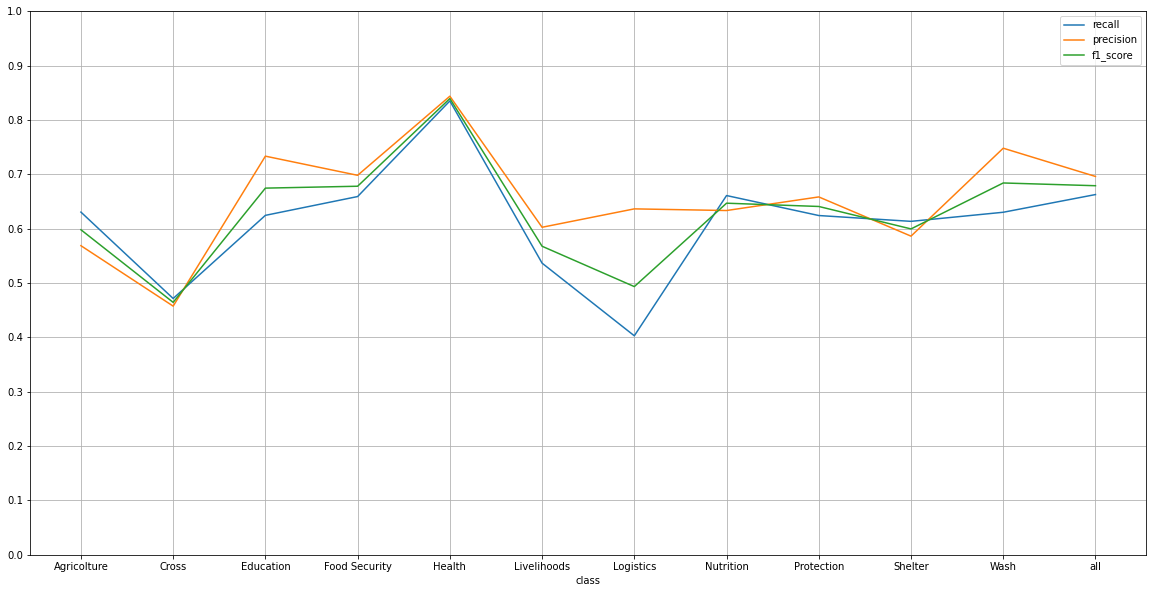

In [45]:
multi_label_metrics.plot(figsize=(20, 10), xticks=range(12), yticks=[x/10 for x in range(11)], 
                         ylim=(0, 1), grid=True, title)

<AxesSubplot:xlabel='class'>

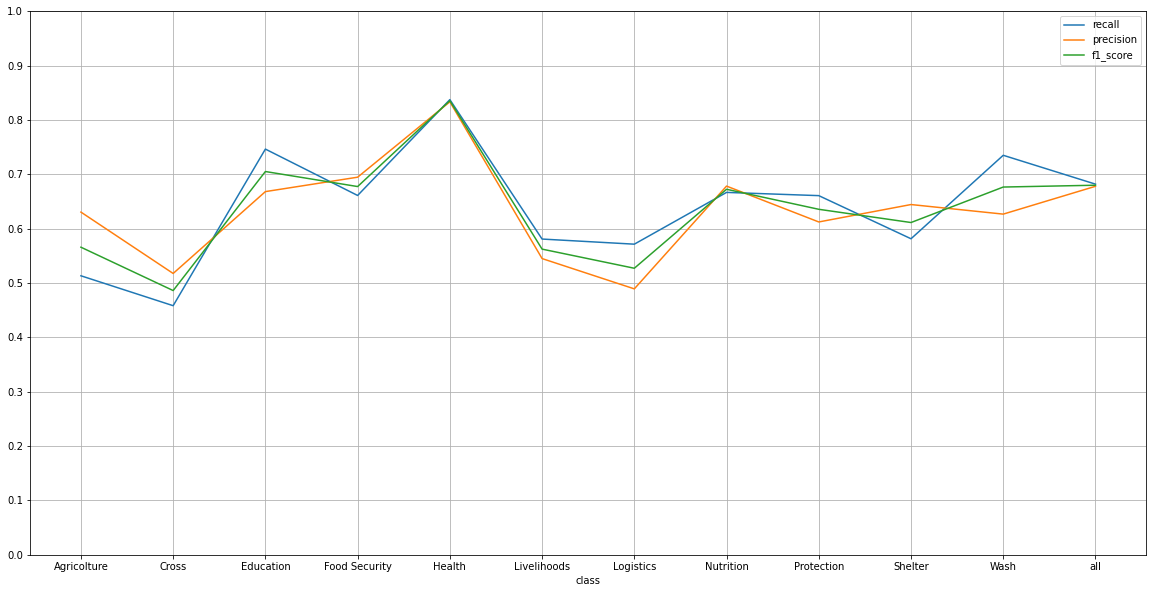

In [49]:
multi_label_metrics.plot(figsize=(20, 10), xticks=range(12), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

In [46]:
base = Path('/home/ec2-user/SageMaker/experiments-dfs/models/fastai/results')

In [47]:
with open(base / 'multi_label_metrics.pickle', 'wb') as f:
    pickle.dump(multi_label_metrics, f)

# Analysis

In [50]:
tp = test_discrete_preds
tt = test_discrete_targets

In [53]:
test_df

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids,is_valid
0,51787,1,"al., 2014; Dell, Jones, and Olken, 2014).",1,Agricolture,True
1,51657,15,"Many orphaned youth live in poverty and have lost their parents to natural disasters, the HIV/AIDS epidemic and other diseases, war, or domestic issues.",1,Education;Livelihoods,True
2,51657,17,Other youth live in shelters or on the streets.,1,Education;Livelihoods,True
3,51542,0,"WFP Colombia Country Brief December 2020 Operational Context The Colombian humanitarian context is complex, with multiple risks and affectations coexisting.",1,Food Security,True
4,51542,2,Colombia has also become the largest host for Venezuelan migrants fleeing dire living conditions in their country.,1,Food Security,True
...,...,...,...,...,...,...
17358,36453,56,"The UN estimates that approximately 90 percent of Syrians live below the poverty line defined by the World Bank as living on less than $2 per day as of June 2020, compared to an estimated 80 percent of Syrians prior to the COVID-19 and economic crises.",1,Livelihoods;Nutrition,True
17670,36069,313,"In the reporting period, UNICEF provided soap through WFP food distributions to 1,150 families in Homs and Hama, and hygiene kits for 1,177 returnees in Idleb.",1,Food Security;Wash,True
17838,36039,99,"In addition, UNICEF report that nutrition activities are ongoing, including group and individual counselling sessions, and nutrition surveillance activities.",1,Education;Nutrition,True
17839,36039,100,"Education activities has also increased in recent weeks, including with partially opened schools reported across most sub-districts where functioning schools existed prior to COVID-19, in light of national exams.",1,Education;Nutrition,True


In [83]:
start = 0

In [84]:
for sentence, sector,p, t, in zip(
    test_df.sentence_text.iloc[start:], 
    test_df.sector_ids.iloc[start:], 
    tp[start:], 
    tt[start:]
):
    if 1 or list(p) != list(t):
        print(sentence)
        t = [classes[i] for i, x in enumerate(t) if x]
        print('Expected:', ', '.join(t))
        p = [classes[i] for i, x in enumerate(p) if x]
        print('Predicted:', ', '.join(p))
    else:
        continue
    
    a = input()
    if a == 's':
        break
    

al., 2014; Dell, Jones, and Olken, 2014).
Expected: Agricolture
Predicted: Protection

Many orphaned youth live in poverty and have lost their parents to natural disasters, the HIV/AIDS epidemic and other diseases, war, or domestic issues.
Expected: Education, Livelihoods
Predicted: Cross, Health, Livelihoods

Other youth live in shelters or on the streets.
Expected: Education, Livelihoods
Predicted: Shelter

WFP Colombia Country Brief December 2020 Operational Context The Colombian humanitarian context is complex, with multiple risks and affectations coexisting.
Expected: Food Security
Predicted: Cross

Colombia has also become the largest host for Venezuelan migrants fleeing dire living conditions in their country.
Expected: Food Security
Predicted: 

The COVID-19 crisis further exacerbates the situation and impacts food security for both Colombians and migrants, especially for those who depend on informal labour, or who are in extreme poverty.
Expected: Food Security
Predicted: Food